In [1]:

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tensorflow.python.tools import freeze_graph


import tensorflow as tf
import numpy as np
import random, os, shutil
# Common imports
import numpy as np
import os
import tensorflow as tf
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

C:\Users\Arjun\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Import data for compute_lammps

# 9 Inputs
# 7 Inputs

import csv
import numpy as np

c_input = np.zeros((35001,9))
c_output = np.zeros((35001,8))

with open('data/Compute_CSV_input.csv', 'r') as fo:
    r=0
    reader = csv.reader(fo)
    for row in reader:
        for i in range(9):
            #print (row[i])
            c_input[r][i]=row[i]
        r=r+1
        if r > 35000:
            break

with open('data/Compute_CSV_output.csv', 'r') as fo:
    r=0
    reader = csv.reader(fo)
    for row in reader:
        for i in range(7):
            #print (row[i])
            c_output[r][i]=row[i]
        r=r+1
        if r > 35000:
            break
                        

(35001, 9)
(35001,)


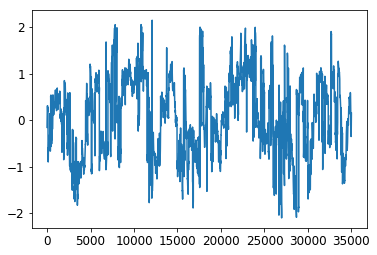

In [4]:
import matplotlib.pyplot as plt

val = 6
print (c_input.shape)
print (c_input[:,val].shape)
plt.plot(c_input[:,val])
plt.show()

In [5]:
# give 20,000 to train
#slice arrays

input_tr = c_input[:25000]
output_tr = c_output[:25000]

print("Training Input shape:",input_tr.shape)
print("Training Output shape:",output_tr.shape)

input_val = c_input[25000:30000]
output_val = c_output[25000:30000]

print("Validation Input shape:",input_val.shape)
print("Validation Output shape:",output_val.shape)


Training Input shape: (25000, 9)
Training Output shape: (25000, 8)
Validation Input shape: (5000, 9)
Validation Output shape: (5000, 8)


In [12]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [13]:
import os
import os.path
import numpy as np
import tensorflow as tf


In [ ]:
## This is the Training code. Run this cell to train.


reset_graph()

# Wrapping all together -> Switch between train and test set using Initializable iterator
EPOCHS = 500

BATCH_SIZE = 150
n_batches =2500



# create a placeholder to dynamically switch between batch sizes
batch_size = tf.placeholder(tf.int64)
x, y = tf.placeholder(tf.float32, shape=[None,9]), tf.placeholder(tf.float32, shape=[None,8])
dataset = tf.contrib.data.Dataset.from_tensor_slices((x, y)).batch(batch_size).repeat()


# using two numpy arrays
train_data = (input_tr,output_tr)
test_data = (input_val,output_val)

iter = dataset.make_initializable_iterator()
features, labels = iter.get_next()

# make a simple model
net1 = tf.layers.dense(features, 32, activation=tf.nn.relu, name="h1") # pass the first value from iter.get_next() as input
net2 = tf.layers.dense(net1, 32,activation=tf.nn.relu, name="h2")
net3= tf.layers.dense(net2,64,activation=tf.nn.relu, name="h3")
net4= tf.layers.dense(net3,32, activation=tf.nn.relu, name="h4")
net5= tf.layers.dense(net4,32, activation=tf.nn.sigmoid, name="h5") # this can have 8 nodes, there is a redundant layer ahead
prediction = tf.layers.dense(net5,8, name="prediction")

loss_vals = np.zeros(650)

cnt =0
loss = tf.losses.mean_squared_error(prediction, labels) # pass the second value from iter.get_net() as label
train_op = tf.train.AdamOptimizer(learning_rate = 0.0002).minimize(loss)


if os.path.exists("SaveFiles"):
    shutil.rmtree("SaveFiles")
#initialize Variables and start session
summary = tf.summary.merge_all()
init = tf.global_variables_initializer()
saver = tf.train.Saver()
sess = tf.Session()
summary_writer = tf.summary.FileWriter("SaveFiles", graph=tf.get_default_graph())
sess.run(init)

#export Graph
tf.train.write_graph(sess.graph_def, "SaveFiles", "Graph.pb")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # initialise iterator with train data
    sess.run(iter.initializer, feed_dict={ x: train_data[0], y: train_data[1], batch_size: BATCH_SIZE})
    print('Training...')
    for i in range(EPOCHS):
        tot_loss = 0
        for _ in range(n_batches):
            _, loss_value = sess.run([train_op, loss])
            tot_loss += loss_value
        print("Iter: {}, Loss: {:.4f}".format(i, tot_loss / n_batches))
        
        loss_vals[cnt] = np.mean((tot_loss / n_batches))
        cnt =cnt+1
        # initialise iterator with test data
    
    checkpoint_file = os.path.join("SaveFiles", 'model.ckpt')
    saver.save(sess, checkpoint_file)

    sess.run(iter.initializer, feed_dict={ x: test_data[0], y: test_data[1], batch_size: test_data[0].shape[0]})
    print('Test Loss: {:4f}'.format(sess.run(loss)))
    
#[print(n.name) for n in tf.get_default_graph().as_graph_def().node]


# Freeze the graph
checkpoint_state_name = "checkpoint"
input_graph_name = "SaveFiles/Graph.pb"
output_graph_name = "SaveFiles/frozen_graph.pb"
input_saver_def_path = ""
input_binary = False
input_checkpoint_path = "SaveFiles/model.ckpt"
output_node_names = "prediction/BiasAdd" 
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
clear_devices = False

freeze_graph.freeze_graph(input_graph_name, input_saver_def_path,
                          input_binary, input_checkpoint_path,
                          output_node_names, restore_op_name,
                          filename_tensor_name, output_graph_name,
                          clear_devices,"")

In [12]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
show_graph(tf.get_default_graph().as_graph_def())
    

In [15]:
'''gdef = tf.GraphDef()
from google.protobuf import text_format
text_format.Merge(open("SaveFiles/Graph.pb").read(), gdef)
show_graph(gdef)'''

In [ ]:
import tensorflow as tf
import sys
from tensorflow.python.platform import gfile

from tensorflow.core.protobuf import saved_model_pb2
from tensorflow.python.util import compat

with tf.Session() as sess:
    model_filename ='SaveFiles/frozen_graph.pb'
    with gfile.FastGFile(model_filename, 'rb') as f:

        data = compat.as_bytes(f.read())
        sm = saved_model_pb2.SavedModel()
        sm.ParseFromString(data)
        #print(sm)
        if 1 != len(sm.meta_graphs):
            print('More than one graph found. Not sure which to write')
            sys.exit(1)

        #graph_def = tf.GraphDef()
        #graph_def.ParseFromString(sm.meta_graphs[0])
        g_in = tf.import_graph_def(sm.meta_graphs[0].graph_def)
LOGDIR='/home/sbaligar/bench'
train_writer = tf.summary.FileWriter(LOGDIR)
train_writer.add_graph(sess.graph)


#[print(n.name) for n in tf.get_default_graph().as_graph_def().node]






In [34]:
## start..............
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tensorflow.python.tools import freeze_graph

import tensorflow as tf
import numpy as np
import random, os, shutil
reset_graph()

In [23]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [24]:
from keras import backend as K

# Create, compile and train model...

frozen_graph = freeze_session(K.get_session(), output_names=[out.op.name for out in model.outputs])

Using TensorFlow backend.


NameError: name 'model' is not defined

In [25]:
tf.train.write_graph(frozen_graph, "some_directory", "my_model.pb", as_text=False)

NameError: name 'frozen_graph' is not defined

In [16]:
test_data[0].shape[0]
loss_vals[100]

1665.5769845356408

In [2]:
from matplotlib.pyplot import figure

figure(num=None, figsize=(8, 6), dpi=180, facecolor='w', edgecolor='k')
#plt.axis([0, 500, 0, 17])
print (loss_vals.size)
plt.plot(loss_vals[:500])
plt.xlabel('Iterations ->')
plt.ylabel('Loss ->')
plt.title('Loss Function for Compute function')
plt.show()

NameError: name 'loss_vals' is not defined

<Figure size 1440x1080 with 0 Axes>

In [26]:
n_epochs = 10
batch_size = 50
dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
#saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    restore_saver.restore(sess, "./my_lammps")
    for epoch in range(n_epochs):
        sess.run(iter.initializer, feed_dict={ x: test_data[0], y: test_data[1], batch_size: test_data[0].shape[0]})
        print('Test Loss: {:4f}'.format(sess.run(loss)))
        
        
        

ValueError: No variables to save

In [ ]:
#Delete Older Saves
	if os.path.exists("SaveFiles"):
		shutil.rmtree("SaveFiles")
	#initialize Variables and start session
	summary = tf.summary.merge_all()
	init = tf.global_variables_initializer()
	saver = tf.train.Saver()


# Freeze the graph
checkpoint_state_name = "checkpoint"
input_graph_name = "SaveFiles/Graph.pb"
output_graph_name = "SaveFiles/frozen_graph.pb"
input_saver_def_path = ""
input_binary = False
input_checkpoint_path = "SaveFiles/model.ckpt-9999"
output_node_names = "Layer2/Output" 
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
clear_devices = False

freeze_graph.freeze_graph(input_graph_name, input_saver_def_path,
                          input_binary, input_checkpoint_path,
                          output_node_names, restore_op_name,
                          filename_tensor_name, output_graph_name,
                          clear_devices,"")

In [19]:
#!/usr/bin/env python
#WorldSmallestNet

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tensorflow.python.tools import freeze_graph

import tensorflow as tf
import numpy as np
import random, os, shutil
reset_graph()


#Define Graph
with tf.Graph().as_default():
	#Placeholder
	X1 = tf.placeholder(tf.float32,[None,1],name="Input")
	Y_ = tf.placeholder(tf.float32,[None,1],name="Label")
	#First Layer
	with tf.name_scope('Layer1'):
		w1 = tf.Variable(tf.constant(0.),name="Weights")
		b1 = tf.Variable(tf.constant(0.1),name="bias")
		X2 = tf.nn.tanh(tf.multiply(X1,w1)+b1)
		tf.summary.scalar("w1",w1)
		tf.summary.scalar("b1",b1)
	#Second Layer
	with tf.name_scope('Layer2'):
		w2 = tf.Variable(tf.constant(0.),name="Weights")
		b2 = tf.Variable(tf.constant(0.1),name="bias")
		Y = tf.nn.sigmoid(tf.multiply(X2,w2)+b2, name="Output")
		tf.summary.scalar("w2",w2)
		tf.summary.scalar("b2",b2)
	#Define Loss and Training Step
	with tf.name_scope('Train'):
		Loss = tf.sqrt(tf.abs(tf.reduce_mean(tf.subtract(Y_,Y))),name="Loss")
		train_step = tf.train.AdamOptimizer(0.01).minimize(Loss)
		tf.summary.scalar("Loss",Loss)
	#Delete Older Saves
	if os.path.exists("SaveFiles"):
		shutil.rmtree("SaveFiles")
	#initialize Variables and start session
	summary = tf.summary.merge_all()
	init = tf.global_variables_initializer()
	saver = tf.train.Saver()
	sess = tf.Session()
	summary_writer = tf.summary.FileWriter("SaveFiles", graph=tf.get_default_graph())
	sess.run(init)
	#export Graph
	tf.train.write_graph(sess.graph_def, "SaveFiles", "Graph.pb")
	#Train Models
	MaxStep = 10000
	for Step in range(MaxStep):
		# make RandomBatches with 0 and 1
		NumberBatch = []
		for i in range(50):
			Number = float(random.randint(0,1))
			NumberBatch.append(Number)
		NumberBatch = np.array(NumberBatch)
		NumberBatch = np.expand_dims(NumberBatch, axis=1)
		# run Training Step
		sess.run(train_step,feed_dict={Y_:NumberBatch,X1:NumberBatch})
		if Step%2 == 0:
			summary_str = sess.run(summary, feed_dict={Y_:NumberBatch,X1:NumberBatch})
			summary_writer.add_summary(summary_str, Step)
			summary_writer.flush()

		# Save Everything at last step
		if Step+1 == MaxStep:
			checkpoint_file = os.path.join("SaveFiles", 'model.ckpt')
			saver.save(sess, checkpoint_file, global_step=Step)
	# Show Results for 0 and 1
	InputTensor0 = [0]
	InputTensor1 = [1]
	InputTensor0 = np.array(InputTensor0)
	InputTensor1 = np.array(InputTensor1)
	InputTensor0 = np.expand_dims(InputTensor0, axis=1)
	InputTensor1 = np.expand_dims(InputTensor1, axis=1)
	print("Input: 0  | Output: ",sess.run(Y,feed_dict={Y_:InputTensor0,X1:InputTensor0}))
	print("Input: 1  | Output: ",sess.run(Y,feed_dict={Y_:InputTensor1,X1:InputTensor1}))

# Freeze the graph
checkpoint_state_name = "checkpoint"
input_graph_name = "SaveFiles/Graph.pb"
output_graph_name = "SaveFiles/frozen_graph.pb.txt"
input_saver_def_path = ""
input_binary = False
input_checkpoint_path = "SaveFiles/model.ckpt-9999"
output_node_names = "Layer2/Output" 
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
clear_devices = False

freeze_graph.freeze_graph(input_graph_name, input_saver_def_path,
                          input_binary, input_checkpoint_path,
                          output_node_names, restore_op_name,
                          filename_tensor_name, output_graph_name,
                          clear_devices,"")

Input: 0  | Output:  [[9.428182e-05]]
Input: 1  | Output:  [[0.9999058]]
INFO:tensorflow:Restoring parameters from SaveFiles/model.ckpt-9999
INFO:tensorflow:Froze 4 variables.
Converted 4 variables to const ops.
